In [2]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
def two_by_three_matrix_num_comparer(df, bus_value, bs_value, mc_value):
    
    # Initialize a 2x3 matrix to hold counts:
    # Row 0 for comparisons between bus and bs.
    # Row 1 for comparisons between bus and mc.
    # Columns: [lower, equal, higher]
    result_matrix = np.zeros((2, 3), dtype=int)
    
    # Compare bus_max_qual with bs_max_qual
    bus_vs_bs_lower = (df[bus_value] < df[bs_value]).sum()
    bus_vs_bs_equal = (df[bus_value] == df[bs_value]).sum()
    bus_vs_bs_higher = (df[bus_value] > df[bs_value]).sum()
    
    # Store counts in the first row of the result matrix
    result_matrix[0, :] = [bus_vs_bs_lower, bus_vs_bs_equal, bus_vs_bs_higher]
    
    # Compare bus_max_qual with mc_max_qual
    bus_vs_mc_lower = (df[bus_value] < df[mc_value]).sum()
    bus_vs_mc_equal = (df[bus_value] == df[mc_value]).sum()
    bus_vs_mc_higher = (df[bus_value] > df[mc_value]).sum()
    
    # Store counts in the second row of the result matrix
    result_matrix[1, :] = [bus_vs_mc_lower, bus_vs_mc_equal, bus_vs_mc_higher]
    
    # Create a DataFrame from the result_matrix with appropriate headers
    comparison_df = pd.DataFrame(
        result_matrix,
        columns=['loss', 'tie', 'win'],
        index=['vs Beam Search', 'vs MCTS4DM']
    )
    
    # print(comparison_df)
    
    print(comparison_df.to_latex())
    
    
    
def create_boolean_comparison_df(df, entities, suffixes):
    """
    Creates a 2xN DataFrame counting how often combined conditions across specified suffixes 
    for each entity are True or False.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        entities (list of str): List of entity prefixes (e.g., ['bs', 'mc', 'bus']).
        suffixes (list of str): List of suffixes to combine with OR for each entity 
                                (e.g., ['ts_found', '>_ts', 'sts_found']).
                                
    Returns:
        pd.DataFrame: A 2x(len(entities)) DataFrame with counts of True and False 
                      for combined conditions per entity.
    """
    # Initialize a 2 x len(entities) matrix for counts
    result_matrix = np.zeros((2, len(entities)), dtype=int)

    for idx, entity in enumerate(entities):
        # Start with a False series of the same length as df
        combined_condition = pd.Series([False] * len(df), index=df.index)
        
        # Combine conditions across all specified suffixes using OR
        for suffix in suffixes:
            column_name = f'{entity}_{suffix}'
            # Check if the column exists before combining, to avoid KeyError
            if column_name in df.columns:
                combined_condition |= df[column_name]
        
        # Count True and False occurrences in the combined condition
        true_count = combined_condition.sum()  
        false_count = (~combined_condition).sum()  
        
        # Store counts in the result matrix
        result_matrix[0, idx] = true_count
        result_matrix[1, idx] = false_count

    # Create a DataFrame from the result_matrix with proper row and column labels
    comparison_df = pd.DataFrame(
        result_matrix,
        index=[True, False],  
        columns=entities      
    )
    
    # print(comparison_df)
    print(' ')
    print(comparison_df.to_latex())
    print(' ')
    
def compare_bus_scores(df):
    """
    Compute a matrix comparing bus scores to bs and mc scores.
    
    For each entity (bs, mc, bus), if '<entity>_>_ts' is True then the score is 1,
    otherwise the score is taken from '<entity>_ts_cover'.
    After computing these derived scores, this function compares bus_score against 
    bs_score and mc_score, counting how often bus is win, tie, or loss.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing columns:
            - '<entity>_>_ts' (boolean)
            - '<entity>_ts_cover' (numeric)
          for entities 'bs', 'mc', and 'bus'.
    
    Returns:
        pd.DataFrame: A 2x3 matrix DataFrame summarizing counts of occurrences 
                      when bus scores loss, tie, or win than bs and mc.
    """
    # Define entities involved in comparisons
    entities = ['bs', 'mc', 'bus']

    # Compute derived scores for each entity
    for entity in entities:
        df[f'{entity}_score'] = np.where(
            df[f'{entity}_>_ts'],     # if condition is true
            1,                        # then score = 1
            df[f'{entity}_ts_cover']  # otherwise use ts_cover
        )

    # Compare bus_score to bs_score and mc_score, count outcomes
    comparisons = {
        'bus_vs_bs': {
            'win': (df['bus_score'] > df['bs_score']).sum(),
            'tie':  (df['bus_score'] == df['bs_score']).sum(),
            'loss':  (df['bus_score'] < df['bs_score']).sum()
        },
        'bus_vs_mc': {
            'win': (df['bus_score'] > df['mc_score']).sum(),
            'tie':  (df['bus_score'] == df['mc_score']).sum(),
            'loss':  (df['bus_score'] < df['mc_score']).sum()
        }
    }

    # Initialize a 2x3 result matrix
    result_matrix = np.zeros((2, 3), dtype=int)

    # Fill in the matrix for bus vs bs (first row) and bus vs mc (second row)
    result_matrix[0, :] = [
        comparisons['bus_vs_bs']['loss'],
        comparisons['bus_vs_bs']['tie'],
        comparisons['bus_vs_bs']['win']
    ]
    result_matrix[1, :] = [
        comparisons['bus_vs_mc']['loss'],
        comparisons['bus_vs_mc']['tie'],
        comparisons['bus_vs_mc']['win']
    ]

    # Create a DataFrame from the result matrix with appropriate labels
    comparison_df = pd.DataFrame(
        result_matrix,
        index=['vs bs', 'vs mc'],
        columns=['loss', 'tie', 'win']
    )

    return comparison_df


def time_comparison(df):
    
    df['bus_to_mc'] = df['bus_time'] / df['mc_time']
    df['bus_to_bs'] = df['bus_time'] / df['bs_time']
    
    # Define bin width
    bin_width = 0.2
    
    # Determine suitable min and max for binning based on your data or expected range
    min_ratio = 0  # adjust if necessary
    max_ratio = max(df['bus_to_mc'].max(), df['bus_to_bs'].max()) + bin_width
    
    bins = np.arange(min_ratio, max_ratio + bin_width, bin_width)
    
    #TODO Save results
    
    plt.figure(figsize=(8, 5))
    plt.hist(df['bus_to_mc'], bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('Bus/MC Ratio')
    plt.ylabel('Occurrences')
    plt.title('Histogram of Bus/MC Ratio with Bin Width 0.05')
    plt.xticks(bins, rotation=90)  # Rotate if x-tick labels overlap
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.hist(df['bus_to_bs'], bins=bins, color='salmon', edgecolor='black')
    plt.xlabel('Bus/BS Ratio')
    plt.ylabel('Occurrences')
    plt.title('Histogram of Bus/BS Ratio with Bin Width 0.05')
    plt.xticks(bins, rotation=90)
    plt.tight_layout()
    plt.show()


import numpy as np
from scipy.stats import friedmanchisquare, studentized_range
from math import sqrt

def transform_to_ranks(df, columns):
    """
    Transforms a dataframe with performance columns into a rank matrix suitable for the Friedman test.
    
    Parameters:
    - df: A pandas DataFrame containing dataset results.
    - columns: A list of column names corresponding to the performance of algorithms.
    
    Returns:
    - A numpy array where rows correspond to datasets and columns contain the ranks of algorithms.
    """
    # Extract the relevant columns
    relevant_data = df[columns]
    
    # Handle boolean values: Convert True/False to 1/0
    relevant_data = relevant_data.map(lambda x: 1 if x is True else (0 if x is False else x))
    
    # Convert rows to ranks (lower values = better rank, handle ties)
    ranks = relevant_data.rank(axis=1, method="average", ascending=False).to_numpy()
    
    return np.array(ranks.astype(int))


# Critical values for the Nemenyi test based on Demšar (2006)
nemenyi_critical_values = {
    0.10: {  # Significance level alpha = 0.10
        2: 1.645,
        3: 2.052,
        4: 2.291,
        5: 2.460,
        6: 2.589,
        7: 2.692,
        8: 2.778,
        9: 2.851,
        10: 2.915,
        11: 2.971,
        12: 3.021,
        13: 3.066,
        14: 3.106,
        15: 3.142,
        16: 3.176,
        17: 3.207,
        18: 3.235,
        19: 3.261,
        20: 3.285,
    },
    0.05: {  # Significance level alpha = 0.05
        2: 1.960,
        3: 2.343,
        4: 2.569,
        5: 2.728,
        6: 2.850,
        7: 2.948,
        8: 3.031,
        9: 3.102,
        10: 3.164,
        11: 3.219,
        12: 3.268,
        13: 3.312,
        14: 3.352,
        15: 3.388,
        16: 3.421,
        17: 3.451,
        18: 3.478,
        19: 3.503,
        20: 3.526,
    },
    0.01: {  # Significance level alpha = 0.01
        2: 2.576,
        3: 3.314,
        4: 3.764,
        5: 4.043,
        6: 4.242,
        7: 4.397,
        8: 4.527,
        9: 4.639,
        10: 4.736,
        11: 4.820,
        12: 4.894,
        13: 4.960,
        14: 5.020,
        15: 5.076,
        16: 5.126,
        17: 5.173,
        18: 5.217,
        19: 5.258,
        20: 5.296,
    }
}



def friedman_stat(df, bus_value, bs_value, mc_value, nemenyi_critical_values = nemenyi_critical_values, print_output=False):

    # Step 1: Input data (Ranks for each dataset)
    ranks = transform_to_ranks(df, [bus_value, bs_value, mc_value]) # np.array([
    #     [3, 1, 2, 4],  # Dataset 1
    #     [3, 2, 1, 4],  # Dataset 2
    #     [1, 3, 2, 4],  # Dataset 3
    #     [2, 3, 1, 4],  # Dataset 4
    #     [1, 4, 2, 3],  # Dataset 5
    # ])
    
    # Number of datasets (N) and algorithms (k)
    N, k = ranks.shape
    
    # Step 2: Average ranks
    average_ranks = ranks.mean(axis=0)
    
    # Step 3: Friedman statistic
    friedman_stat, p_value = friedmanchisquare(*ranks.T)
     
    # Iman-Davenport adjustment for small sample sizes
    F_F = ((N - 1) * friedman_stat) / (N * (k - 1) - friedman_stat)
     
    # # Step 4: Nemenyi Test - Critical Difference (CD)
    alpha = 0.05  # Significance level

    q_alpha = nemenyi_critical_values[alpha][k]
    CD = q_alpha * sqrt(k * (k + 1) / (6 * N))

    # Step 5: Pairwise comparisons
    pairwise_differences = np.abs(np.subtract.outer(average_ranks, average_ranks))

    # Check significance of pairwise differences
    significant_pairs = pairwise_differences > CD
    
    results = {
        "Average Ranks": average_ranks,
        "Friedman Statistic": friedman_stat,
        "p-value": p_value,
        "Iman-Davenport F": F_F,
        "Critical Difference (CD)": CD,
        "Pairwise Differences": pairwise_differences,
        "Significant Differences": significant_pairs
    }
    if print_output:
        print('Average ranks (bus,bs,mc)= ', average_ranks.round(3))
        print('Friedman Statistic= ', round(friedman_stat,3))
        print('p-value= ', round(p_value,5))
        print('Iman-Davenport F= ', round(F_F,3))
        print("Critical Difference (CD)= ", round(CD,2))
        print("Pairwise Differences= ", pairwise_differences)
        print("Significant Differences= ", significant_pairs)
    return     'Average ranks (bus,bs,mc)= '+ str(average_ranks.round(3))+' Friedman Statistic= '+ str(round(friedman_stat,3))+' p-value= '+ str(round(p_value,5))+' Iman-Davenport F= '+ str(round(F_F,3))+ " Critical Difference (CD)= "+ str(round(CD,2))+" Pairwise Differences= "+ str(pairwise_differences)+" Significant Differences= " + str(significant_pairs)
    

## Part 1

Below you'll find the synthetic results for a different set of parameters <br>
Here the synthetic results for:

In [4]:
file_path_results = 'E2 for analysis/E2.1.1_synthetic_data_experiment_202501071808.pkl'
file_path_meta = 'E2 for analysis/E2.1.1_synthetic_data_experiment_202501071808_meta.pkl'

df = pd.read_pickle(file_path_results)
df_meta = pd.read_pickle(file_path_meta)

print("Meta")
print(" ")
print(df_meta)
print(" ")
print(" ")
print("Columns: Meta")
print(" ")
experiment_columns = df.columns[:9]
print(experiment_columns)
print(" ")
print(" ")
print("Columns: Result")
print(" ")
result_columns = df.columns[9:]
print(len(result_columns))
print(result_columns)
print(" ")
print(" ")

Meta
 
{'experiment_start_time': '20250107180807', 'experiment_end_time': '20250111012922', 'nr_experiment': 480, 'nr_attrs': [16, 32], 'true_subgroup_attributes_list': [2, 3], 'n_s': [500, 1000], 'nr_tps': [48], 'nr_iterations': 5, 'dev_sgs': [0.1, 0.5, 1], 'outliers_percs': [0.01, 0.05], 'delta_mu_s': [1, 2], 'd': 3, 'q': 10, 'bins': 5, 'min_cov': 0.01, 'conf_bs': {'w': 50, 'comparison_type_bs': 'complement', 'ensure_diversity': True, 'allow_exclusion_bs': False, 'min_coverage_abs_bs': 3, 'min_error': 0.001, 'correct_for_size': <function no_size_corr at 0x000001BDC465A0C0>}, 'conf_mc': {'allow_exclusion_ms': False, 'minutes': 'dependant on BUSPaS time', 'ucb_type': 'SP-MCTS', 'ucb_params': {}, 'size_correction_method': <function no_size_corr at 0x000001BDC465A0C0>, 'roll_out_strategy': 'direct-freq', 'reward_policy': 'max_path', 'reward_policy_k': 3, 'memory_policy': 'all', 'memory_policy_k_value': 3, 'update_policy': 'max_update', 'update_policy_k': 3}, 'conf_bus': {'number_of_row_p

In [40]:
file_path_meta

'E2 for analysis/E2.1.1_synthetic_data_experiment_202501071808_meta.pkl'

In [41]:
list(result_columns[:12])

# 'bs_ts_found' = indicates if true subgroup descriptions is found (True or False, True is best)
# 'bs_>_ts' = indicates if all found subgroups are better than true subgroup  (True or False, used to see if it makes sense to look at _ts_found)
# 'bs_sts_found' =  indicating is a subset of the description has been found of size d (True or False, True is best)
# 'bs_time' = time of algorithm
# 'bs_time_q' =  time of quality
# 'bs_#q' =  number of qualities calculated
# 'bs_ts_cover' = similarity score between true subgroup and best matching found subgroup (0-1, 1 is best)
# X 'bs_max_qual' = maximum quality (num, the win, the better)
# X 'bs_red_0.5' = redundancy (0-1, 1 is worst)
# X 'bs_red_0.7' = redundancy (0-1, 1 is worst)
# X 'bs_div_0.5' = diversity (num, the win, the better)
# X 'bs_div_0.7' = diversity (num, the win the better)

['bs_ts_found',
 'bs_>_ts',
 'bs_sts_found',
 'bs_time',
 'bs_time_q',
 'bs_#q',
 'bs_ts_cover',
 'bs_max_qual',
 'bs_red_0.5',
 'bs_red_0.7',
 'bs_div_0.5',
 'bs_div_0.7']

In [42]:
print("max quality")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df, bus_value = 'bus_max_qual', bs_value = 'bs_max_qual', mc_value = 'mc_max_qual')
print('\caption{',friedman_stat(df, 'bus_max_qual', 'bs_max_qual', 'mc_max_qual'),'}')
print('\end{table}')
print(" ")
print(" ")
print("diversity 0.5")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df, bus_value = 'bus_div_0.5', bs_value = 'bs_div_0.5', mc_value = 'mc_div_0.5')
print('\caption{',friedman_stat(df, 'bus_div_0.5', 'bs_div_0.5', 'mc_div_0.5'),'}')
print('\end{table}')

print(" ")
print(" ")
print("diversity 0.7")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df, bus_value = 'bus_div_0.7', bs_value = 'bs_div_0.7', mc_value = 'mc_div_0.7')
print('\caption{',friedman_stat(df, 'bus_div_0.7', 'bs_div_0.7', 'mc_div_0.7'),'}')
print('\end{table}')

print(" ")
print(" ")
print("redundancy 0.5")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df, bus_value = 'bus_red_0.5', bs_value = 'bs_red_0.5', mc_value = 'mc_red_0.5')
print('\caption{',friedman_stat(df, 'bus_red_0.5', 'bs_red_0.5', 'mc_red_0.5'),'}')
print('\end{table}')
print(" ")
print(" ")
print("redundancy 0.7")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df, bus_value = 'bus_red_0.7', bs_value = 'bs_red_0.7', mc_value = 'mc_red_0.7')
print('\caption{',friedman_stat(df, 'bus_red_0.7', 'bs_red_0.7', 'mc_red_0.7'),'}')
print('\end{table}')


print(" ")
print(" ")
print("running time")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df, bus_value = 'bus_time', bs_value = 'bs_time', mc_value = 'mc_time')
print('\caption{',friedman_stat(df, 'bus_time', 'bs_time', 'mc_time'),'}')
print('\end{table}')
print(" ")
print(" ")
print("qualities checked")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df, bus_value = 'bus_#q', bs_value = 'bs_#q', mc_value = 'mc_#q')
print('\caption{',friedman_stat(df, 'bus_#q', 'bs_#q', 'mc_#q'),'}')
print('\end{table}')

print(" ")
print(" ")
print("subgroups found")
suffixes = ['ts_found', '>_ts', 'sts_found']

for i in range(len(suffixes)):
    create_boolean_comparison_df(df, ['bs', 'mc', 'bus'], suffixes[:i+1])
print(" ")
print(" ")
print("cover redundancy")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df, bus_value = 'bus_ts_cover', bs_value = 'bs_ts_cover', mc_value = 'mc_ts_cover')
print('\caption{',friedman_stat(df, 'bus_ts_cover', 'bs_ts_cover', 'mc_ts_cover'),'}')
print('\end{table}')

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\e'
<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:49: SyntaxWarning: invalid escape sequence '\c'
<>:50: SyntaxWarning: invalid escape sequence '\e'
<>:55: SyntaxWarning: invalid escape sequence '\c'
<>:57: SyntaxWarning: invalid esca

max quality
\begin{table}[ht]
\centering
 
\begin{tabular}{lrrr}
\toprule
 & loss & tie & win \\
\midrule
vs Beam Search & 0 & 472 & 8 \\
vs MCTS4DM & 0 & 159 & 321 \\
\bottomrule
\end{tabular}

 
\caption{ Average ranks (bus,bs,mc)= [1.331 1.365 2.652] Friedman Statistic= 605.897 p-value= 0.0 Iman-Davenport F= 819.605 Critical Difference (CD)= 0.15 Pairwise Differences= [[0.         0.03333333 1.32083333]
 [0.03333333 0.         1.2875    ]
 [1.32083333 1.2875     0.        ]] Significant Differences= [[False False  True]
 [False False  True]
 [ True  True False]] }
\end{table}
 
 
diversity 0.5
\begin{table}[ht]
\centering
 
\begin{tabular}{lrrr}
\toprule
 & loss & tie & win \\
\midrule
vs Beam Search & 0 & 449 & 31 \\
vs MCTS4DM & 55 & 0 & 425 \\
\bottomrule
\end{tabular}

 
\caption{ Average ranks (bus,bs,mc)= [1.115 1.185 2.765] Friedman Statistic= 550.949 p-value= 0.0 Iman-Davenport F= 645.163 Critical Difference (CD)= 0.15 Pairwise Differences= [[0.         0.07083333 1.65      

C:\Users\bengelen004\AppData\Local\Temp\ipykernel_25316\957425998.py:308: RuntimeWarning: divide by zero encountered in scalar divide
  F_F = ((N - 1) * friedman_stat) / (N * (k - 1) - friedman_stat)


In [21]:
compare_bus_scores(df)

,loss,tie,win
vs bs,0,472,8
vs mc,0,283,197


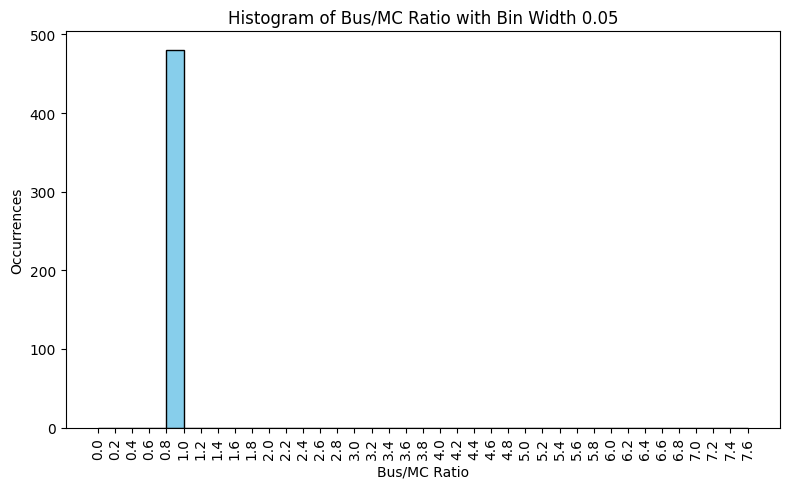

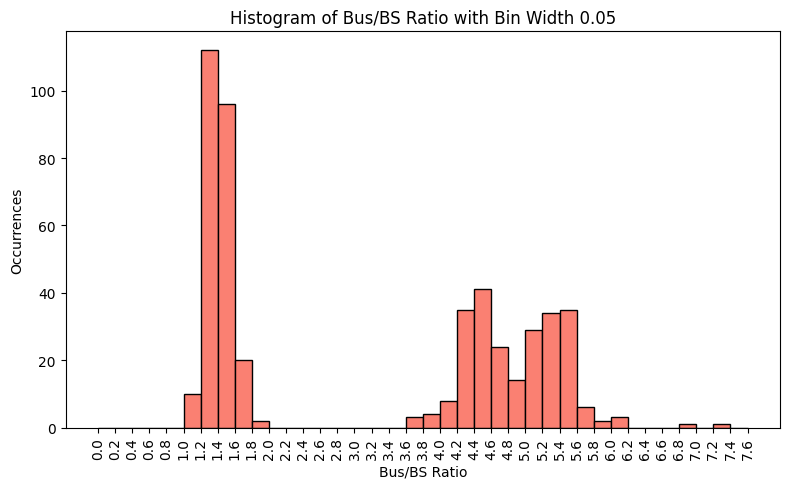

In [22]:
time_comparison(df)


## Part 2: 

In [5]:
file_path_results_E212 = 'E2 for analysis/E2.1.2_synthetic_data_experiment_202501202131.pkl'
file_path_meta_E212 = 'E2 for analysis/E2.1.2_synthetic_data_experiment_202501202131_meta.pkl'

df_E212 = pd.read_pickle(file_path_results_E212)
df_meta_E212 = pd.read_pickle(file_path_meta_E212)

In [6]:
df_E212

,exp_id,iter.,N,T,k,lits,o,delta_mu,dev_sg,bs_ts_found,...,bus_sts_found,bus_time,bus_time_q,bus_#q,bus_ts_cover,bus_max_qual,bus_red_0.5,bus_red_0.7,bus_div_0.5,bus_div_0.7
0,-6594374310800186225,1,500,48,16,2,0.01,1,0.1,True,...,True,2.629758,0.604798,908,1.000000,9.939,0.1,0.0,83.764488,93.612762
1,-6594374310800186225,2,500,48,16,2,0.01,1,0.1,False,...,True,2.334857,0.545188,863,1.000000,10.233,0.1,0.0,82.517250,91.983337
2,-6594374310800186225,3,500,48,16,2,0.01,1,0.1,True,...,True,2.146182,0.486014,746,1.000000,8.954,0.1,0.0,77.505058,86.305107
3,-6594374310800186225,4,500,48,16,2,0.01,1,0.1,True,...,True,3.022439,0.720732,1116,0.622951,10.491,0.0,0.0,102.402946,102.402946
4,-6594374310800186225,5,500,48,16,2,0.01,1,0.1,True,...,True,5.528153,1.275491,1126,1.000000,8.497,0.1,0.0,75.882706,84.305664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-2852595880789445913,1,1000,48,32,3,0.05,2,1.0,False,...,True,41.344479,16.311179,7808,1.000000,2.064,0.0,0.0,11.960032,11.960032
476,-2852595880789445913,2,1000,48,32,3,0.05,2,1.0,True,...,True,39.854116,15.831714,7800,1.000000,2.020,0.0,0.0,12.100229,12.100229
477,-2852595880789445913,3,1000,48,32,3,0.05,2,1.0,False,...,True,42.943836,16.950223,8337,1.000000,2.090,0.0,0.0,11.817291,11.817291
478,-2852595880789445913,4,1000,48,32,3,0.05,2,1.0,False,...,True,54.835204,21.813330,10805,1.000000,2.075,0.0,0.0,11.928946,11.928946


In [7]:
# file_path_results = 'E2 for analysis/E2.1.1_synthetic_data_experiment_202501071808.pkl'
# file_path_meta = 'E2 for analysis/E2.1.1_synthetic_data_experiment_202501071808_meta.pkl'
# 
# df = pd.read_pickle(file_path_results)
# df_meta = pd.read_pickle(file_path_meta)

print("Meta")
print(" ")
print(df_meta_E212)
print(" ")
print(" ")
print("Columns: Meta")
print(" ")
experiment_columns = df_E212.columns[:9]
print(experiment_columns)
print(" ")
print(" ")
print("Columns: Result")
print(" ")
result_columns = df_E212.columns[9:]
print(len(result_columns))
print(result_columns)
print(" ")
print(" ")
print("Columns: Result")
print(" ")
result_columns = df_E212.columns[9:]
print(len(result_columns))
print(result_columns)
print(" ")
print(" ")

Meta
 
{'experiment_start_time': '20250120213137', 'experiment_end_time': '20250121055923', 'nr_experiment': 480, 'nr_attrs': [16, 32], 'true_subgroup_attributes_list': [2, 3], 'n_s': [500, 1000], 'nr_tps': [48], 'nr_iterations': 5, 'dev_sgs': [0.1, 0.5, 1], 'outliers_percs': [0.01, 0.05], 'delta_mu_s': [1, 2], 'd': 3, 'q': 10, 'bins': 5, 'min_cov': 0.01, 'conf_bs': {'w': 20, 'comparison_type_bs': 'complement', 'ensure_diversity': True, 'allow_exclusion_bs': False, 'min_coverage_abs_bs': 3, 'min_error': 0.01, 'correct_for_size': <function no_size_corr at 0x000001BDC465A0C0>}, 'conf_mc': {'allow_exclusion_ms': False, 'minutes': 'dependant on BUSPaS time', 'ucb_type': 'SP-MCTS', 'ucb_params': {}, 'size_correction_method': <function no_size_corr at 0x000001BDC465A0C0>, 'roll_out_strategy': 'direct-freq', 'reward_policy': 'max_path', 'reward_policy_k': 3, 'memory_policy': 'all', 'memory_policy_k_value': 3, 'update_policy': 'max_update', 'update_policy_k': 3}, 'conf_bus': {'number_of_row_pa

In [8]:
print("max quality")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df_E212, bus_value = 'bus_max_qual', bs_value = 'bs_max_qual', mc_value = 'mc_max_qual')
print('\caption{',friedman_stat(df_E212, 'bus_max_qual', 'bs_max_qual', 'mc_max_qual'),'}')
print('\end{table}')
print(" ")
print(" ")
print("diversity 0.5")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df_E212, bus_value = 'bus_div_0.5', bs_value = 'bs_div_0.5', mc_value = 'mc_div_0.5')
print('\caption{',friedman_stat(df_E212, 'bus_div_0.5', 'bs_div_0.5', 'mc_div_0.5'),'}')
print('\end{table}')

print(" ")
print(" ")
print("diversity 0.7")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df_E212, bus_value = 'bus_div_0.7', bs_value = 'bs_div_0.7', mc_value = 'mc_div_0.7')
print('\caption{',friedman_stat(df_E212, 'bus_div_0.7', 'bs_div_0.7', 'mc_div_0.7'),'}')
print('\end{table}')

print(" ")
print(" ")
print("redundancy 0.5")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df_E212, bus_value = 'bus_red_0.5', bs_value = 'bs_red_0.5', mc_value = 'mc_red_0.5')
print('\caption{',friedman_stat(df_E212, 'bus_red_0.5', 'bs_red_0.5', 'mc_red_0.5'),'}')
print('\end{table}')
print(" ")
print(" ")
print("redundancy 0.7")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df_E212, bus_value = 'bus_red_0.7', bs_value = 'bs_red_0.7', mc_value = 'mc_red_0.7')
print('\caption{',friedman_stat(df_E212, 'bus_red_0.7', 'bs_red_0.7', 'mc_red_0.7'),'}')
print('\end{table}')

print(" ")
print(" ")
print("running time")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df_E212, bus_value = 'bus_time', bs_value = 'bs_time', mc_value = 'mc_time')
print('\caption{',friedman_stat(df_E212, 'bus_time', 'bs_time', 'mc_time'),'}')
print('\end{table}')
print(" ")
print(" ")
print("qualities checked")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df_E212, bus_value = 'bus_#q', bs_value = 'bs_#q', mc_value = 'mc_#q')
print('\caption{',friedman_stat(df_E212, 'bus_#q', 'bs_#q', 'mc_#q'),'}')
print('\end{table}')

print(" ")
print(" ")
print("subgroups found")
suffixes = ['ts_found', '>_ts', 'sts_found']

for i in range(len(suffixes)):
    create_boolean_comparison_df(df_E212, ['bs', 'mc', 'bus'], suffixes[:i+1])
print(" ")
print(" ")
print("cover redundancy")
print("\\begin{table}[ht]")
print("\centering")
two_by_three_matrix_num_comparer(df = df_E212, bus_value = 'bus_ts_cover', bs_value = 'bs_ts_cover', mc_value = 'mc_ts_cover')
print('\caption{',friedman_stat(df_E212, 'bus_ts_cover', 'bs_ts_cover', 'mc_ts_cover'),'}')
print('\end{table}')

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\e'
<>:46: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\c'
<>:49: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid esca

max quality
\begin{table}[ht]
\centering
\begin{tabular}{lrrr}
\toprule
 & loss & tie & win \\
\midrule
vs Beam Search & 24 & 437 & 19 \\
vs MCTS4DM & 0 & 93 & 387 \\
\bottomrule
\end{tabular}

\caption{ Average ranks (bus,bs,mc)= [1.225 1.25  2.769] Friedman Statistic= 687.456 p-value= 0.0 Iman-Davenport F= 1208.215 Critical Difference (CD)= 0.15 Pairwise Differences= [[0.      0.025   1.54375]
 [0.025   0.      1.51875]
 [1.54375 1.51875 0.     ]] Significant Differences= [[False False  True]
 [False False  True]
 [ True  True False]] }
\end{table}
 
 
diversity 0.5
\begin{table}[ht]
\centering
\begin{tabular}{lrrr}
\toprule
 & loss & tie & win \\
\midrule
vs Beam Search & 190 & 162 & 128 \\
vs MCTS4DM & 55 & 0 & 425 \\
\bottomrule
\end{tabular}

\caption{ Average ranks (bus,bs,mc)= [1.51  1.415 2.738] Friedman Statistic= 430.107 p-value= 0.0 Iman-Davenport F= 388.798 Critical Difference (CD)= 0.15 Pairwise Differences= [[0.         0.09583333 1.22708333]
 [0.09583333 0.         1.32

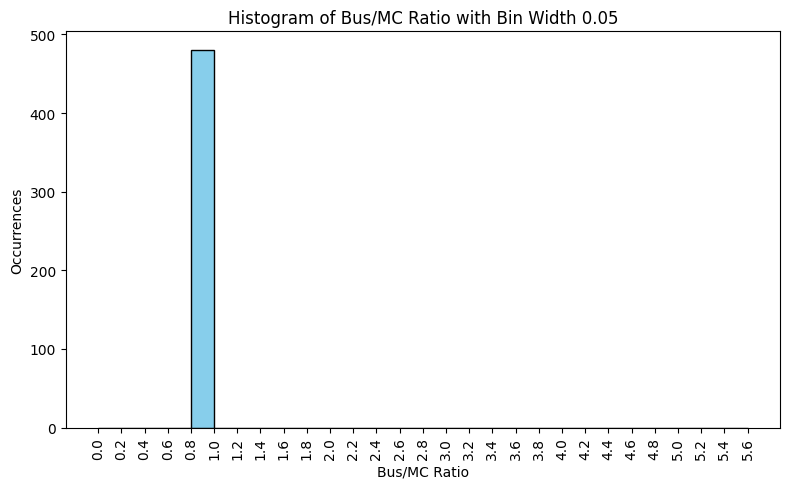

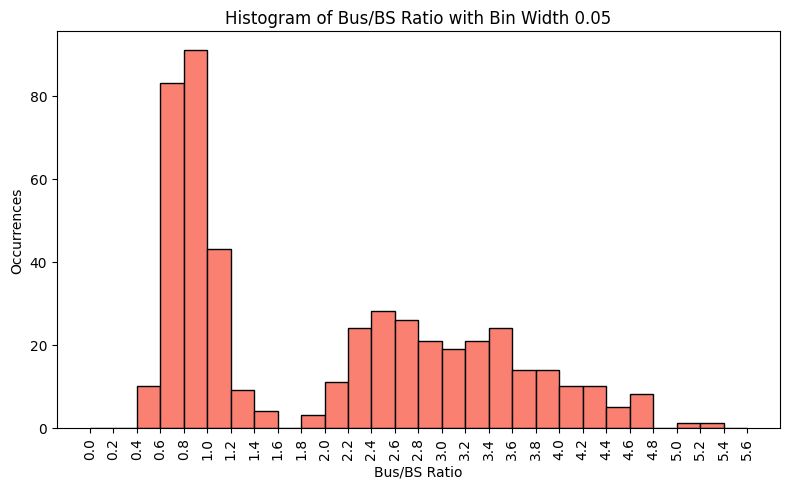

In [27]:
time_comparison(df_E212)